In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [2]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

CPU times: user 2min 18s, sys: 11.8 s, total: 2min 29s
Wall time: 2min 30s


   acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691
(629145480, 2)


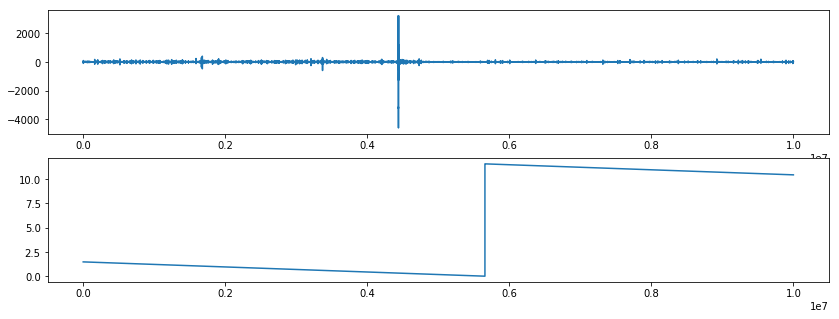

In [3]:

print(train.head())
print(train.shape)
#print(test.head())
#print(test.shape)
#629.145.480 629 milions rows for easy and fast processing get only first 10.000.000 10 milions rows
small_train=train[0:10000000]
small_train.shape
#plot acustic data secuence first 10 milions rows
fig,ax=plt.subplots(2,1,figsize=(17,17))
small_train['acoustic_data'].plot(figsize=(14,5),ax=ax[0])
small_train['time_to_failure'].plot(figsize=(14,5),ax=ax[1])
#lets try to catch a earthquake moment
#629.145.480 629 milions rows for easy and fast processing get only first 10.000.000 10 milions rows

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Mean time between signals--> -8.943799066027058e-07 MAX time between signals--> 0.0010954966000000094 MIN time between signals--> -11.54000450717705


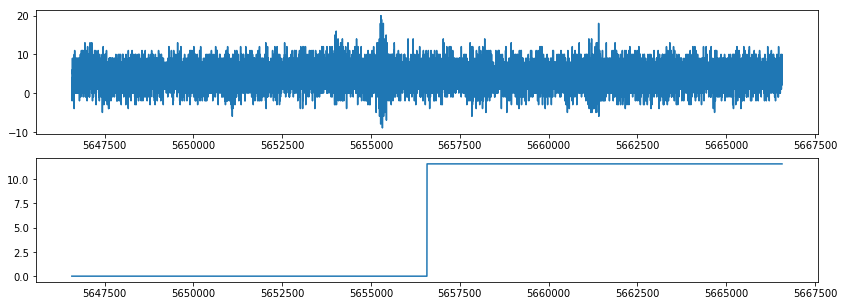

In [4]:
#we whant check few acustic data before and after earthquake
first_quake=small_train[(small_train['time_to_failure']>small_train['time_to_failure'].shift(1))].head().index[0]
catch_train=train[first_quake-10000:first_quake+10000]
catch_train.shape

#plot acustic data secuence first 10 milions rows
fig,ax=plt.subplots(2,1,figsize=(17,17))
catch_train['acoustic_data'].plot(figsize=(14,5),ax=ax[0])
catch_train['time_to_failure'].plot(figsize=(14,5),ax=ax[1])
#calculate time between acustics signals
small_train['time-1'] = small_train['time_to_failure'].shift(-1)
small_train['dif_time'] = small_train['time_to_failure']-small_train['time-1']
print("Mean time between signals-->",small_train['dif_time'].mean(),"MAX time between signals-->",small_train['dif_time'].max(),"MIN time between signals-->",small_train['dif_time'].min())
#small_train['dif_time'].plot(figsize=(14,5))



In [5]:
#we try to do agrupations of N_SIGNALS
GROUPS=250

def c_std(series):
    return np.std(series)

windows=[2,3,5,8,13,21,34]
def getsample(input_set):
    #final_sample=input_set
    final_sample=pd.DataFrame(np.array(input_set).reshape((len(input_set),1)),columns=['acoustic_data'])
    final_sample.index = pd.to_datetime(final_sample.index,unit="s")
    #print("final_sample",final_sample.shape)
    mdata= final_sample.resample(str(GROUPS)+"s").agg(
        #{'acoustic_data' : ['first',max,min,'last','mean',c_std]    
         {'acoustic_data' : ['first',max,min,'last']    
        }    
    )
    mdata.columns=mdata.columns.droplevel(0)
    #print("mdata",mdata.shape)

    for window in windows:
        mdata['mafirst{}'.format(window)]=mdata['first'].rolling(window).mean()
        mdata['mamax{}'.format(window)]=mdata['max'].rolling(window).mean()
        mdata['mamin{}'.format(window)]=mdata['min'].rolling(window).mean()
        mdata['malast{}'.format(window)]=mdata['last'].rolling(window).mean()
   #     mdata['mamean{}'.format(window)]=mdata['mean'].rolling(window).mean()
   #     mdata['macstd{}'.format(window)]=mdata['c_std'].rolling(window).mean()                
    mdata=(mdata[windows[-1]:]-5)/3
    #for x in mdata.columns:
     #   mdata[x]=(mdata[x]-mdata[x].min())/(mdata[x].max-mdata[x].min())
    return mdata


In [6]:
randitem=123234
NUM_INPUT_ITEMS=150000
demo=train[randitem:randitem+NUM_INPUT_ITEMS]
#print(demo.head())
final=getsample(demo["acoustic_data"])
print(final)
print(final.shape) #means 48 features
NUM_STEPS=final.shape[0]
FEATURES=final.shape[1]

                        first       max    ...      mamin34  malast34
1970-01-01 02:21:40  0.333333  3.000000    ...    -3.343137 -0.284314
1970-01-01 02:25:50 -0.666667  2.666667    ...    -3.235294 -0.274510
1970-01-01 02:30:00 -0.333333  2.666667    ...    -3.147059 -0.323529
1970-01-01 02:34:10 -0.333333  2.000000    ...    -3.098039 -0.313725
1970-01-01 02:38:20  0.666667  2.666667    ...    -3.078431 -0.313725
1970-01-01 02:42:30  0.333333  3.000000    ...    -3.039216 -0.294118
1970-01-01 02:46:40  0.000000  2.333333    ...    -3.019608 -0.254902
1970-01-01 02:50:50 -1.000000  2.333333    ...    -2.960784 -0.225490
1970-01-01 02:55:00 -0.333333  2.333333    ...    -2.941176 -0.215686
1970-01-01 02:59:10  1.000000  3.333333    ...    -2.970588 -0.215686
1970-01-01 03:03:20 -1.000000  2.333333    ...    -2.980392 -0.205882
1970-01-01 03:07:30 -1.000000  2.000000    ...    -2.960784 -0.186275
1970-01-01 03:11:40  0.333333  2.333333    ...    -2.950980 -0.176471
1970-01-01 03:15:50 

In [7]:
NUM_INPUT_ITEMS=150000
MAX_ITEM=train.shape[0]-NUM_INPUT_ITEMS
print(MAX_ITEM)
BATCH_SIZE=32
def generator():
    while True:
        X_train=np.zeros((BATCH_SIZE,NUM_STEPS,FEATURES))
        y_train=np.zeros((BATCH_SIZE,1))
        
        for x in range(BATCH_SIZE):            
            while True:
                start=np.random.randint(0,MAX_ITEM)
                pd_sample=train[start:start+NUM_INPUT_ITEMS]      
                #print(pd_sample.shape)
                npdata=np.array(getsample(pd_sample["acoustic_data"]))     
                if npdata.shape[0]>=NUM_STEPS:
                    break                      
                
            #NORM
            #npdata=np.array((pd_sample["acoustic_data"]-MIN)/(MAX-MIN))            
            #STAND
            #npdata=np.array((pd_sample["acoustic_data"]-MEAN)/STD)
            #print(npdata.shape)
            npdata=npdata.reshape(NUM_STEPS,FEATURES)                            
            # y_train[x]=pd_sample['time_to_failure'][NUM_INPUT_ITEMS-1]
            #print(pd_sample)
            y_train[x]=(np.array(pd_sample['time_to_failure'])[NUM_INPUT_ITEMS-1])/16
            X_train[x]=npdata
        yield X_train,y_train
X,y=next(generator())    
print(X.shape)
print(y.shape)
print(X)
print(y)


628995480
(32, 566, 32)
(32, 1)
[[[ 3.33333333e-01  3.00000000e+00 -2.66666667e+00 ...  3.12745098e+00
   -3.09803922e+00 -8.82352941e-02]
  [ 2.66666667e+00  1.93333333e+01 -1.83333333e+01 ...  3.62745098e+00
   -3.55882353e+00 -1.07843137e-01]
  [ 3.00000000e+00  1.30000000e+01 -1.06666667e+01 ...  3.92156863e+00
   -3.78431373e+00 -1.66666667e-01]
  ...
  [ 0.00000000e+00  2.33333333e+00 -3.00000000e+00 ...  4.74509804e+00
   -5.00980392e+00  3.13725490e-01]
  [-3.33333333e-01  3.33333333e+00 -2.33333333e+00 ...  4.79411765e+00
   -5.00000000e+00  3.13725490e-01]
  [-3.33333333e-01  3.33333333e+00 -3.00000000e+00 ...  4.81372549e+00
   -5.00000000e+00  3.23529412e-01]]

 [[-3.33333333e-01  3.66666667e+00 -3.66666667e+00 ...  4.31372549e+00
   -5.10784314e+00 -8.82352941e-02]
  [-2.00000000e+00  2.33333333e+00 -3.66666667e+00 ...  4.32352941e+00
   -5.11764706e+00 -3.92156863e-02]
  [-1.00000000e+00  4.00000000e+00 -7.33333333e+00 ...  4.37254902e+00
   -5.23529412e+00  9.80392157e-0

In [8]:
# Define model
from keras.models import Sequential
from keras.layers import Dense,LSTM,Bidirectional,CuDNNGRU
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
def root_mean_squared_logarithmic_error(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1)+0.0000001)
def cust_mae(y_true, y_pred):
    return K.mean(K.abs((K.exp(y_pred) - K.exp(y_true))), axis=-1)+0.0000001

def cust_maev2(y_true, y_pred):
    return K.mean(K.abs((((y_pred)*16) - ((y_true)*16))), axis=-1)+0.0000001

Using TensorFlow backend.


In [9]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
inp = Input(shape=(NUM_STEPS,FEATURES))
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(inp)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
conc = Dense(64, activation="relu")(conc)
conc = Dropout(0.1)(conc)
outp = Dense(1,activation="sigmoid")(conc)
#outp = Dense(1, activation="sigmoid")(conc)

model = Model(inputs=inp, outputs=outp)

print("DONE")

DONE


In [10]:


checkpoint = ModelCheckpoint('model.h5', verbose=1, monitor='loss',save_best_only=True, mode='auto')
model.compile(loss='mae', optimizer='adam', metrics=['mae',cust_mae,cust_maev2])
#model = Sequential()
#model.add(CuDNNGRU(48, input_shape=(NUM_STEPS, FEATURES)))
#model.add(Dense(10, activation='relu'))
#model.add((LSTM(120, return_sequences=True,input_shape=(NUM_STEPS, FEATURES))))
#model.add((LSTM(60, return_sequences=False)))
#model.add(Dense(50, activation='relu'))
#model.add(Dense(1))

# Compile and fit model
#model.compile(optimizer=adam(), loss="logcosh",metrics=['mae',cust_mae])
#model.summary()



In [ ]:
history = model.fit_generator(generator(),
                              steps_per_epoch=100,
                              epochs=80,
                              verbose=1,
                              callbacks=[checkpoint])